In [1]:
import bwd
import numpy as np
from numpy.random import default_rng
from onorm import MinMaxScaler

In [2]:
rng = default_rng(2022)

n = 10000
d = 5
ate = 1
beta = rng.normal(size=d)

X = rng.normal(size=(n, d))

balancer = bwd.BWD(N=n, D=d)
normalizer = MinMaxScaler(n_dim=d)
A_bwd = []
A_rand = []
imbalance_bwd = np.array([[0] * d])
imbalance_rand = np.array([[0] * d])


def increment_imbalance(imba, a, x):
    return np.concatenate([imba, imba[-1:, :] + (2 * a - 1) * x])


for x in X:
    normalizer.partial_fit(x)
    x_trans = normalizer.transform(x)
    a_bwd = balancer.assign_next(x_trans)
    A_bwd.append(a_bwd)
    imbalance_bwd = increment_imbalance(imbalance_bwd, a_bwd, x)
    a_rand = rng.binomial(n=1, p=0.5, size=1).item()
    imbalance_rand = increment_imbalance(imbalance_rand, a_rand, x)
    A_rand.append(a_rand)

# Outcomes are only realized at the conclusion of the experiment
eps = rng.normal(size=n)
Y_bwd = X @ beta + A_bwd * ate + eps
Y_rand = X @ beta + A_rand + ate + eps

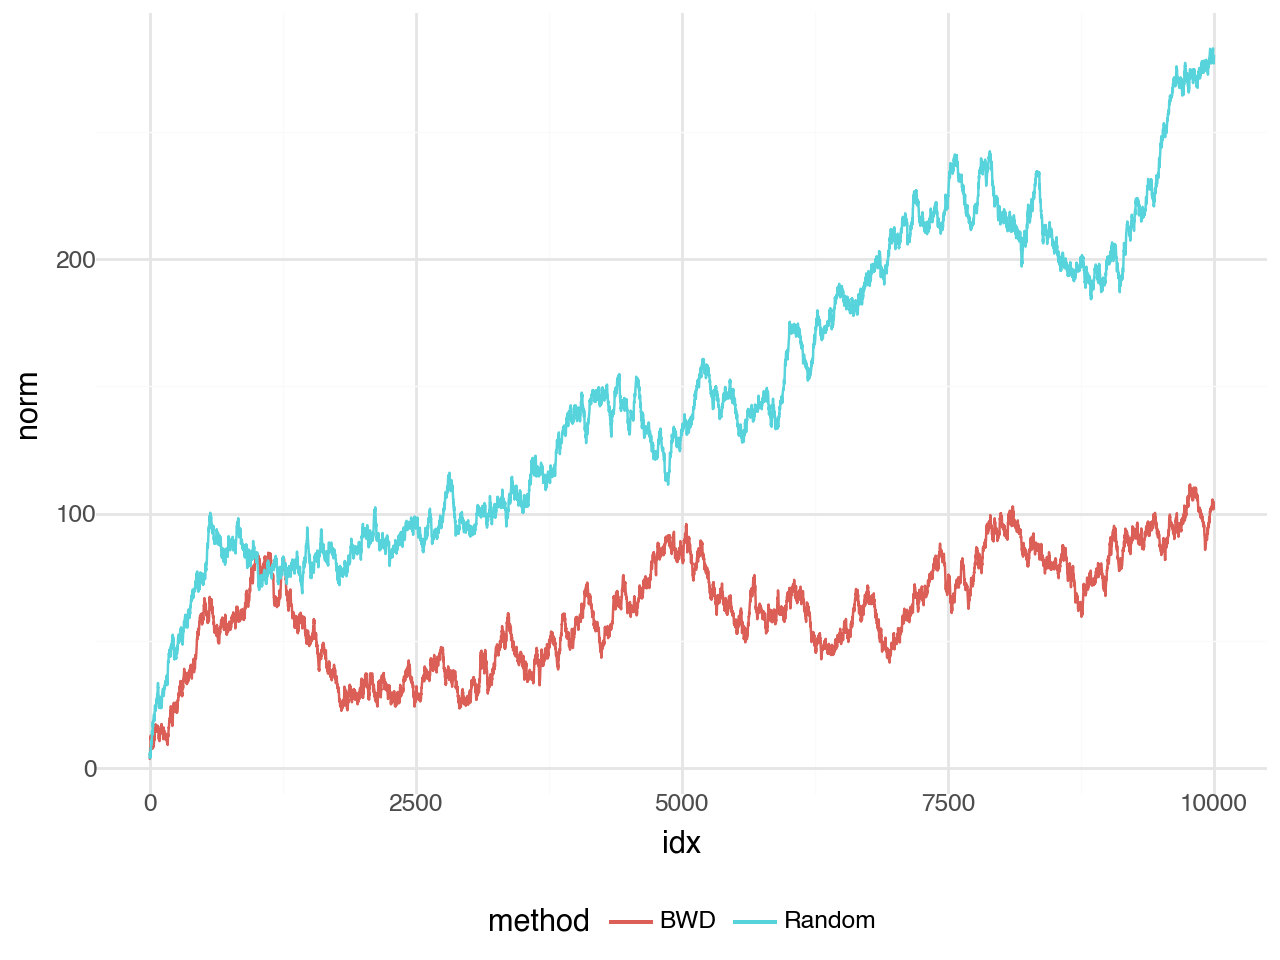

In [3]:
import pandas as pd
from plotnine import aes, geom_line, ggplot, theme, theme_minimal

norm_bwd = np.linalg.norm(imbalance_bwd, axis=1)[1:].tolist()
norm_rand = np.linalg.norm(imbalance_rand, axis=1)[1:].tolist()

df = pd.DataFrame(
    {
        "idx": list(np.arange(n)) * 2,
        "norm": norm_bwd + norm_rand,
        "method": ["BWD"] * n + ["Random"] * n,
    }
)

(
    ggplot(df, aes("idx", "norm", color="method"))
    + geom_line()
    + theme_minimal()
    + theme(legend_position="bottom")
)

In [4]:
from copy import deepcopy
from functools import reduce

import pandas as pd
from simulator import Bernoulli, Evaluator, Linear, Model, NoisedNormal, Normal, Unnormalizer

models = [
    Model("BWD + MinMax", MinMaxScaler(n_dim=d), bwd.BWD(N=n, D=d)),
    Model("BWD", Unnormalizer(), bwd.BWD(N=n, D=d)),
    Model("Bernoulli + MinMax", MinMaxScaler(n_dim=d), Bernoulli()),
    Model("Bernoulli", Unnormalizer(), Bernoulli()),
]

# Having to do the deepcopy is hacky.
# Should be able to get a different simulation for each call to .evaluate()
# Just need to have a "reset_state()" method in the assigners, which requires change
# in BWD.
evaluators = [
    Evaluator(n=n, xdgp=Normal(d=d), ydgp=Linear(), models=deepcopy(models)),
    Evaluator(n=n, xdgp=NoisedNormal(d=d), ydgp=Linear(), models=deepcopy(models)),
]

[evaluator.evaluate() for evaluator in evaluators]

results = reduce(lambda x, y: x + y, [evaluator.results for evaluator in evaluators])

df = pd.DataFrame.from_records(results)
df

,xdgp,ydgp,model,metric,value
0,Normal,Linear,BWD + MinMax,elapsed_time,0.141211
1,Normal,Linear,BWD + MinMax,imbalance,0.018941
2,Normal,Linear,BWD + MinMax,causal_error,0.003309
3,Normal,Linear,BWD,elapsed_time,0.078799
4,Normal,Linear,BWD,imbalance,0.017063
5,Normal,Linear,BWD,causal_error,-0.032272
6,Normal,Linear,Bernoulli + MinMax,elapsed_time,0.050912
7,Normal,Linear,Bernoulli + MinMax,imbalance,0.044982
8,Normal,Linear,Bernoulli + MinMax,causal_error,0.017459
9,Normal,Linear,Bernoulli,elapsed_time,0.011336


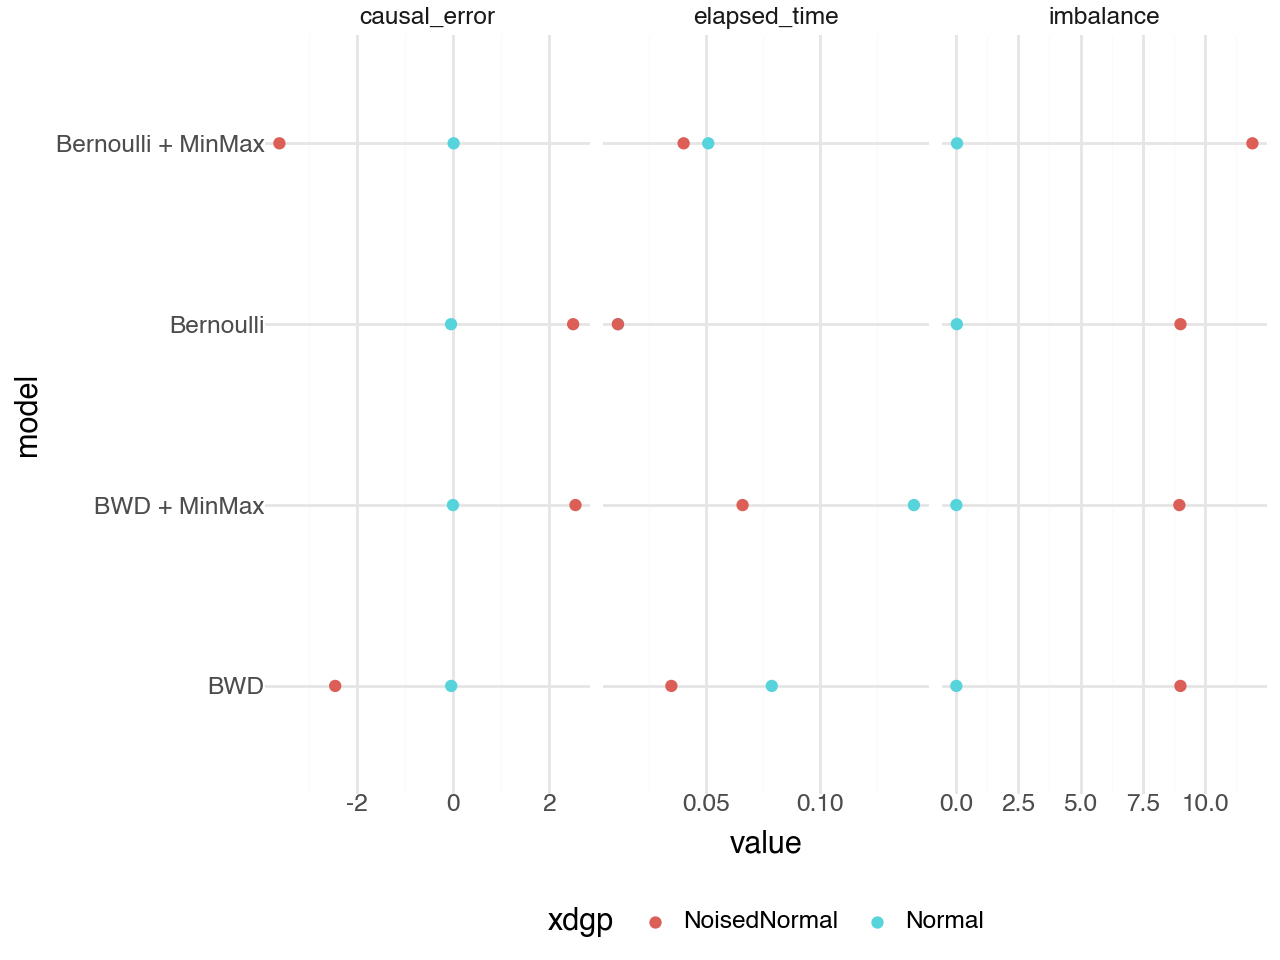

In [8]:
from plotnine import coord_flip, facet_wrap, geom_point

(
    ggplot(df, aes("model", "value", color="xdgp"))
    + geom_point()
    + facet_wrap("metric", scales="free_x")
    + coord_flip()
    + theme_minimal()
    + theme(legend_position="bottom")
)